In [1]:
import os
import pickle

def load_or_compute(pickle_path, compute_func, *args, **kwargs):
    if os.path.exists(pickle_path):
        with open(pickle_path, "rb") as f:
            return pickle.load(f)
    
    result = compute_func(*args, **kwargs)
    
    with open(pickle_path, "wb") as f:
        pickle.dump(result, f)
    
    return result

def save_to_pickle(pickle_path,data):
    with open(pickle_path, "wb") as f:
        pickle.dump(data, f)
    
import textwrap

def wrap_title(title, width=25):
    return "\n".join(textwrap.wrap(title, width))


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time,random
import numpy as np
import scipy.stats as scistats

In [3]:
def load_experiment(path):
    df_experiment = pd.read_csv(path)
    df_experiment["warmup_duration"] = df_experiment["warmup_duration"].apply(lambda x: [float(i) for i in str(x).split('|')])
    df_experiment["repetitions_duration"] = df_experiment["repetitions_duration"].apply(lambda x: [float(i) for i in x.split('|')])
    df_experiment['warmup_duration'] = df_experiment['warmup_duration'].apply(lambda x: [] if x == [0.0] else x)
    return df_experiment

In [4]:
EXPERIMENT_25_09_FILE = "../src/build/csv/experiment-25-09-2025.csv"
EXPERIMENT_28_10_FILE = "../src/build/csv/experiment-28-10-2025.csv"

In [5]:
def compare_two_cdf(dataframe,x_name="repetitions_duration",hue_name="version"):
    hue_ = dataframe[hue_name].unique()
    colors = sns.color_palette("tab10", n_colors=len(hue_))
    for i, u_hue in enumerate(hue_):
        temp_df = dataframe[dataframe[hue_name] == u_hue]
        sorted_data = np.sort(temp_df[x_name])
        cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
        plt.plot(sorted_data, cdf, marker=None, color=colors[i],label=u_hue)
    plt.xlabel('x')
    plt.ylabel('CDF')
    plt.title(f'Empirical CDF of execution time')
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
def compare_densities(dataframe,x_name="repetitions_duration",hue_name="version"):
    palette = sns.color_palette("tab10", n_colors=dataframe[hue_name].nunique())
    sns.histplot(
        data=dataframe,
        x=x_name,
        hue=hue_name,
        kde=True,            # overlay KDE
        stat="density",      # normalize histogram to match KDE
        multiple="layer",    # overlay multiple categories
        alpha=0.4,           # transparency
        palette=palette,
    )
    plt.title("Distribution of the execution time")


In [7]:
def plot_comparing_two_versions_single_repetitions(dataframe:pd.DataFrame,warmup=5,repetitions=1000,versions=["ReferenceAccuracy","BCAccuracy"]):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
    temp_df = dataframe[dataframe["warmup"]==warmup]
    temp_df = dataframe[dataframe["repetitions"]==repetitions]
    temp_df = temp_df[temp_df["version"].isin(versions)]
    temp_df = temp_df.drop_duplicates(subset=["repetitions","version"], keep="first")
    temp_df_exploded = temp_df.explode('repetitions_duration')
    fig.suptitle(f"Comparing versions {', '.join(versions)} with repetitions {repetitions}", fontsize=14)

    plt.sca(axs[0])              # Make this axes the active one
    compare_densities(temp_df_exploded,x_name="repetitions_duration",hue_name="version")
    plt.sca(axs[1])
    compare_two_cdf(temp_df_exploded,x_name="repetitions_duration",hue_name="version")
    

    return fig

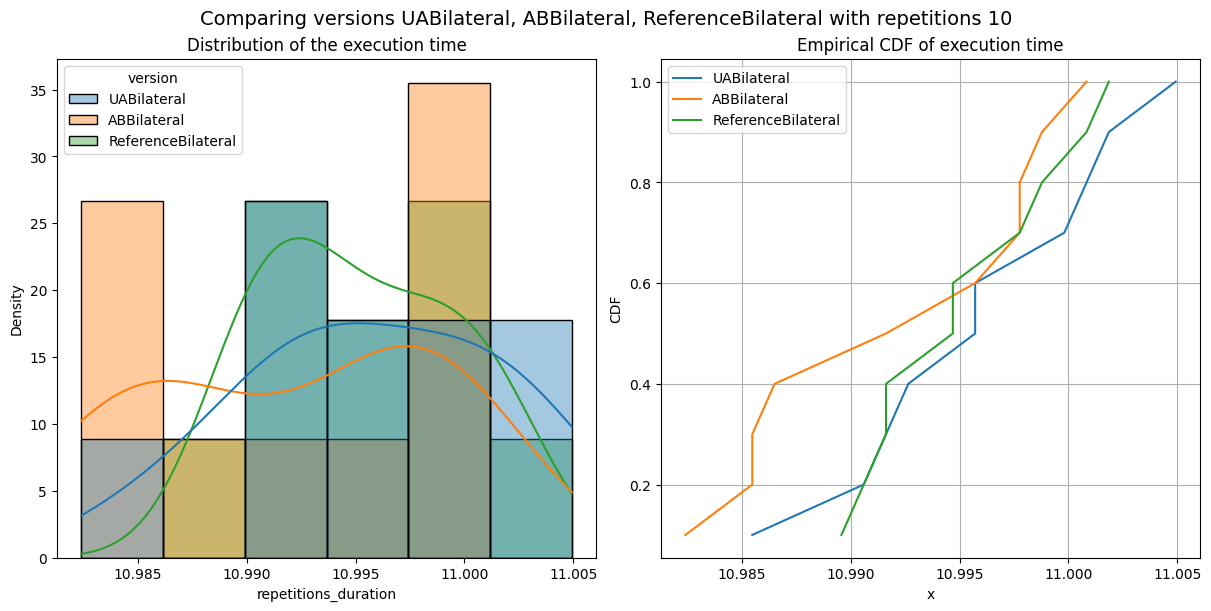

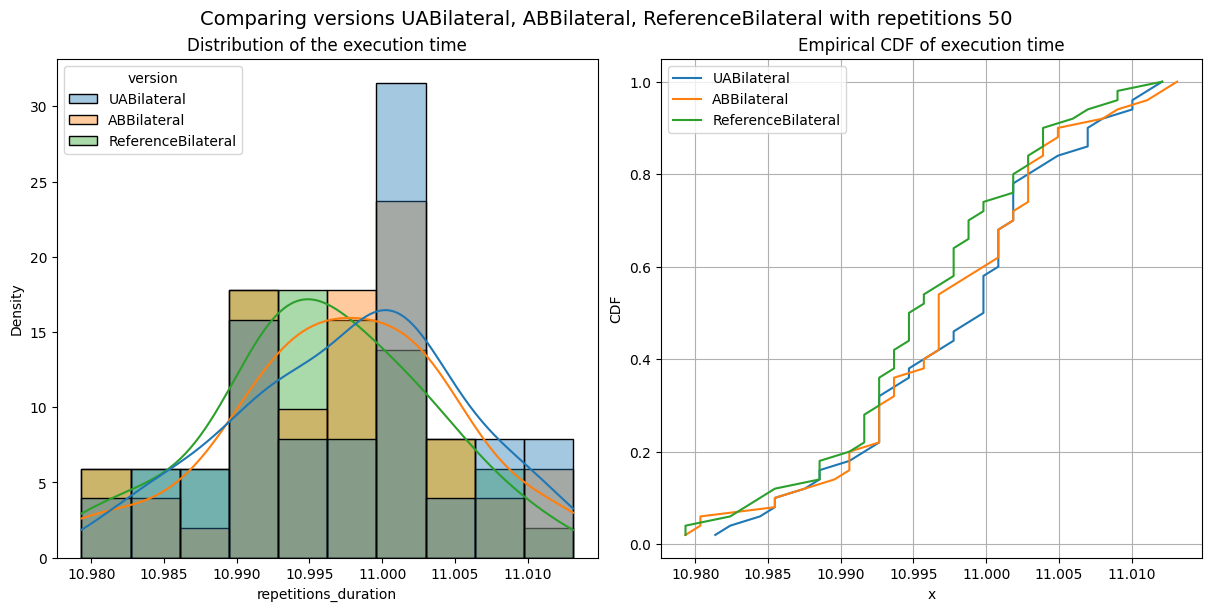

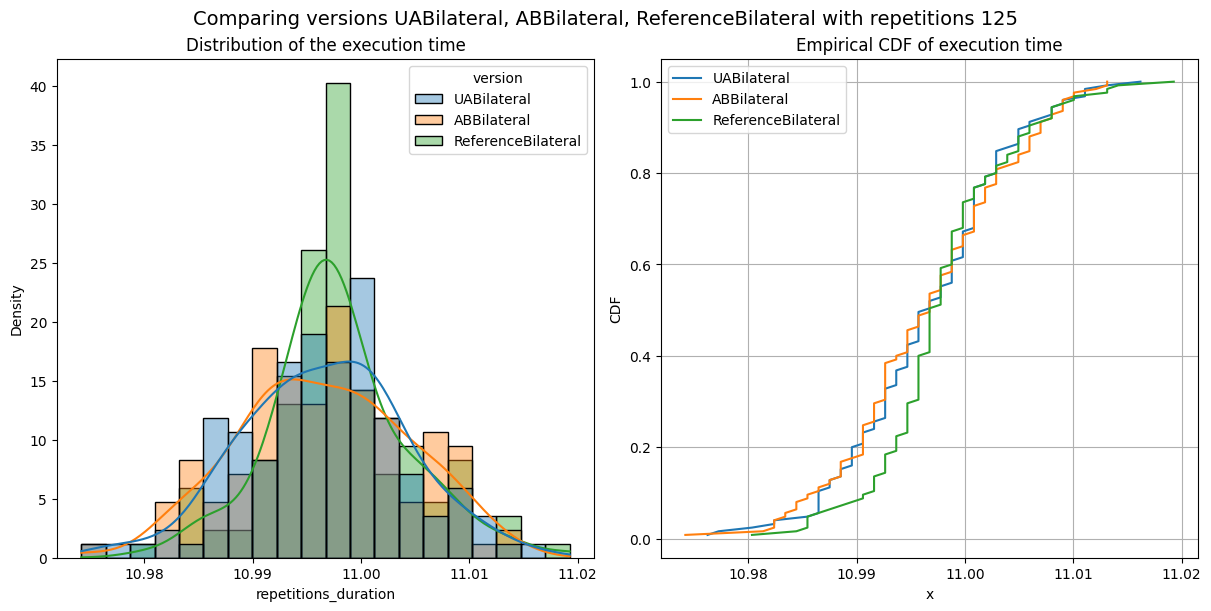

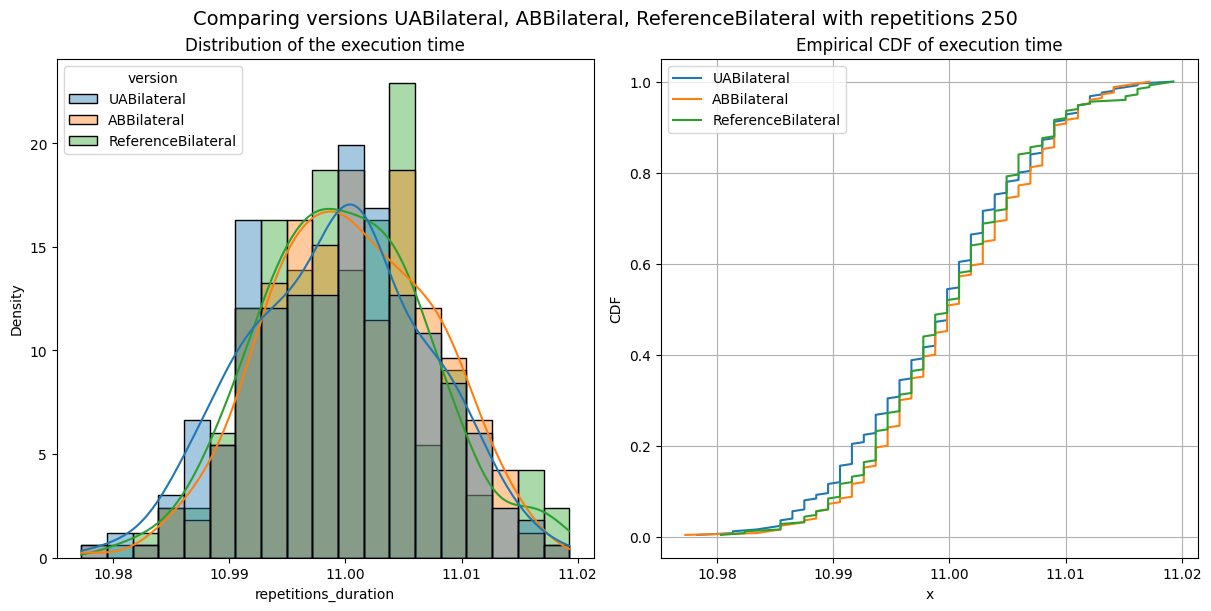

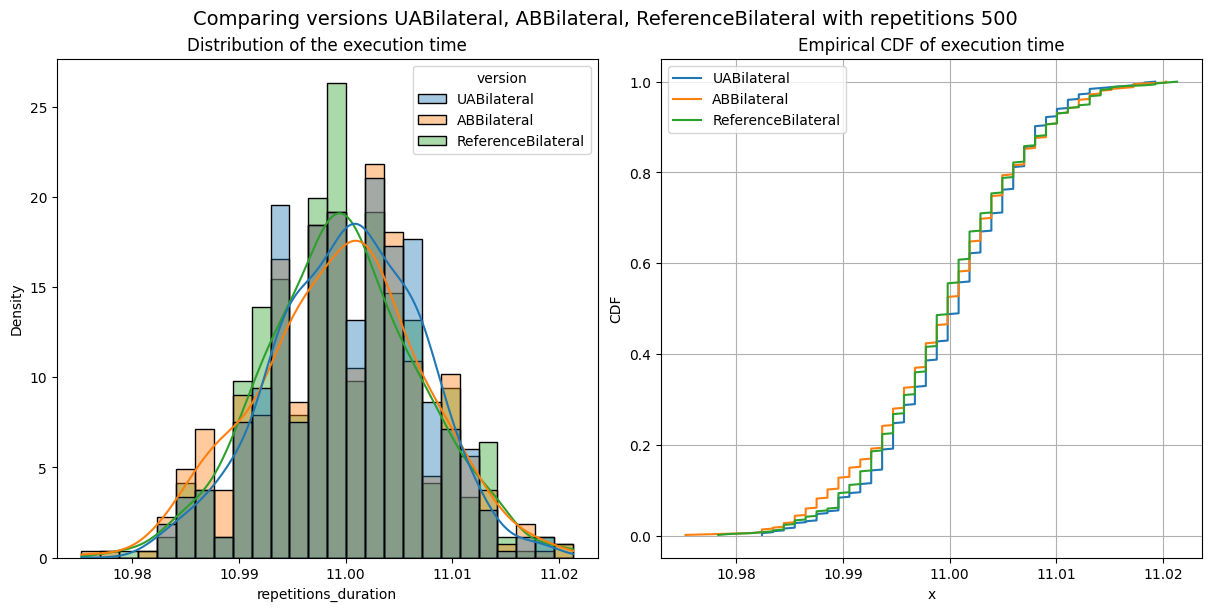

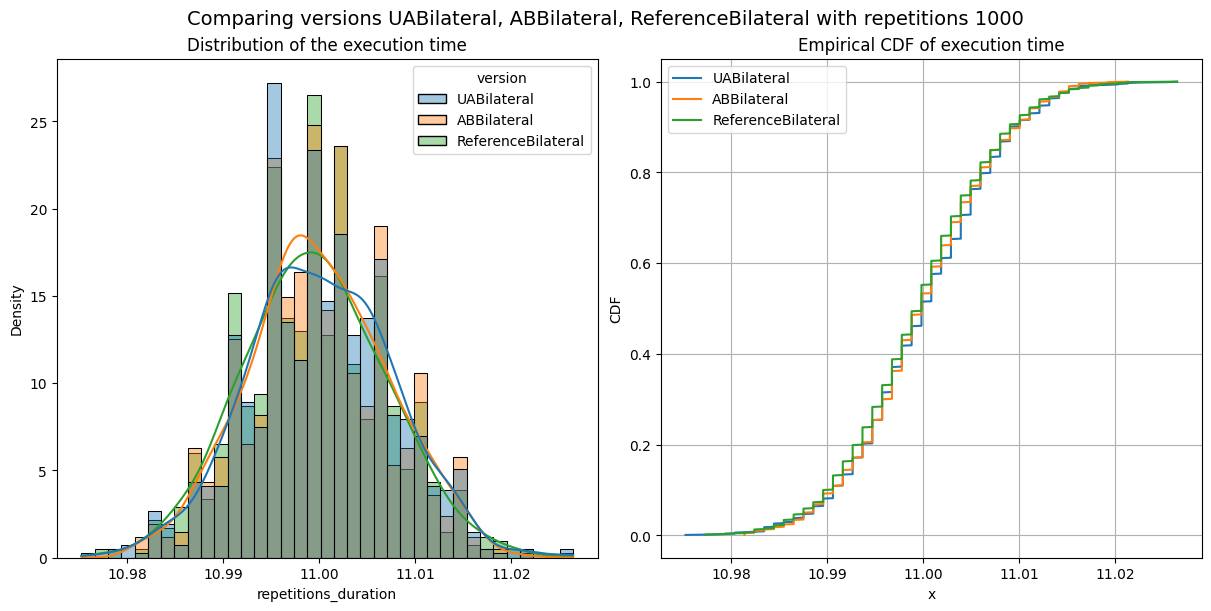

In [8]:
def plot_all_single_kernel_multiple_rep(dataframe):
    versionss = dataframe["version"].unique()
    for repetitions in np.sort(dataframe["repetitions"].unique()):
        g = plot_comparing_two_versions_single_repetitions(dataframe,repetitions=repetitions,versions=versionss)
        plt.show()
        plt.close(g)
        
df_e = load_experiment(EXPERIMENT_25_09_FILE)
temp_df = df_e[df_e["warmup"]==5]
temp_df = temp_df[temp_df["kernel"].str.contains("Bilateral")]
versions = ["ReferenceBilateral","ABBilateral","UABilateral"]
temp_df = temp_df[temp_df["version"].isin(versions)]

plot_all_single_kernel_multiple_rep(temp_df)

In [9]:
from tqdm import tqdm
def boostrap_std(row,confidence):
    res = scistats.bootstrap((row["repetitions_duration"],),np.std,confidence_level=confidence)
    return res.confidence_interval,res.bootstrap_distribution,res.standard_error

def load_n_compute_dataframe(confidence=0.9,dataframe=None,file=EXPERIMENT_25_09_FILE):
    df_e = []
    if dataframe is not None:
        df_e = dataframe.copy()
    else:
        df_e = load_experiment(file)
    df_e['ci_low'] = None
    df_e['ci_high'] = None
    df_e['ci_level'] = confidence
    df_e['boostrap_data'] = None
    df_e['std_error'] = None

    for idx in tqdm(df_e.index):
        conf,data,std = boostrap_std(df_e.loc[idx],confidence)
        df_e.at[idx,'ci_low'] = conf.low
        df_e.at[idx,'ci_high'] = conf.high
        df_e.at[idx,'boostrap_data'] = data
        df_e.at[idx,'std_error'] = std
    return df_e

In [10]:
def plot_multiple_densities(dataframe,hue,x_name="repetitions_duration",weights_=None,title=""):
    palette = sns.color_palette("tab20", n_colors=dataframe[hue].nunique())
    if weights_:
        sns.kdeplot(
            data=dataframe,
            x=x_name,
            weights=dataframe[weights_],  
            hue=hue,
            common_norm=False,
            palette=palette,
            fill=True,
            alpha=0.4
        )
    else:
         sns.kdeplot(
            data=dataframe,
            x=x_name,
            hue=hue,
            common_norm=False,
            palette=palette,
            fill=True,
            alpha=0.4
        )
    plt.title(wrap_title(title,35))


In [11]:
def interval_plot(ix,high,low,horizontal_line_width=0.25,color='#2187bb'):
    width =  horizontal_line_width / 2
    plt.plot([ix, ix], [high, low], color=color)
    plt.plot([ix-width, ix+width], [high, high], color=color)
    plt.plot([ix-width, ix+width], [low, low], color=color)

In [12]:
def compare_std_std_precision(dataframe,precision=0.0005):
    lbls = ['Precision']
    lbls.extend(dataframe["repetitions"].astype(str).tolist())
    plt.xticks(ticks=np.arange(len(lbls)), labels=lbls) 
    middle = np.mean(((dataframe["ci_high"] - dataframe["ci_low"]) / 2) + dataframe["ci_low"])
    interval_plot(0,middle + precision/2,middle - precision/2,color="red")
    for i in range(len(dataframe)):
        interval_plot(i+1,dataframe.iloc[i].ci_high, dataframe.iloc[i].ci_low,color="blue")  
        plt.title(wrap_title("Measure precision vs 90% confidence interval of the standard deviation",40))

In [13]:
def plot_evolution_std_error(dataframe):
    plt.plot(dataframe["repetitions"], dataframe["std_error"], marker='o')
    plt.xlabel("nbr of repetitions")
    plt.ylabel("standard error")
    plt.title("Evolution of Standard error of standard deviation")


In [14]:
def plot_compare_repetitions_single_version(dataframe:pd.DataFrame,warmup=5,version="ReferenceAccuracy"):
    fig, axs = plt.subplots(1, 4, figsize=(16, 6), constrained_layout=True)
    temp_df = dataframe[dataframe["warmup"]==warmup]
    temp_df = temp_df[temp_df["version"].str.contains(version)]
    temp_df = temp_df.drop_duplicates(subset=["repetitions","version"], keep="first")
    temp_df_exploded = temp_df.explode('repetitions_duration')
    temp_df_exploded['weight'] = temp_df_exploded.groupby('repetitions')['repetitions_duration'].transform(lambda x: 1/len(x))
    plt.sca(axs[0])              # Make this axes the active one
    plot_multiple_densities(dataframe=temp_df_exploded,hue="repetitions",weights_='weight',title="Distribution of the execution time")
    
    temp_df_exploded_boot = temp_df.explode('boostrap_data')
    plt.sca(axs[1])
    plot_multiple_densities(temp_df_exploded_boot,hue="repetitions",x_name='boostrap_data',title="Distribution of boostrapped standard deviation")

    plt.sca(axs[2])
    compare_std_std_precision(temp_df)
    plt.sca(axs[3])
    plot_evolution_std_error(temp_df)
    fig.suptitle(f"Comparing Kernel execution time with different number of repetitions for Kernel {version}", fontsize=16)
    return fig


In [15]:
def plot_compare_repetitions_multiple_version(dataframe:pd.DataFrame,warmup=5):
    dataframe_w = dataframe[dataframe["warmup"]==warmup]
    versions = dataframe_w["version"].unique()
    nb_rows = len(versions)
    fig, axs = plt.subplots(nb_rows, 4, figsize=(16, nb_rows*3), constrained_layout=True)
    for i in range(nb_rows):
        temp_df = dataframe_w[dataframe_w["version"].str.contains(versions[i])].copy()
        temp_df = temp_df.drop_duplicates(subset=["repetitions","version"], keep="first")
        temp_df_exploded = temp_df.explode('repetitions_duration')
        temp_df_exploded['weight'] = temp_df_exploded.groupby('repetitions')['repetitions_duration'].transform(lambda x: 1/len(x))
        plt.sca(axs[i][0])              # Make this axes the active one
        plot_multiple_densities(dataframe=temp_df_exploded,hue="repetitions",weights_='weight',title="Distribution of the execution time")
        
        temp_df_exploded_boot = temp_df.explode('boostrap_data')
        plt.sca(axs[i][1])
        plot_multiple_densities(temp_df_exploded_boot,hue="repetitions",x_name='boostrap_data',title="Distribution of boostrapped standard deviation")

        plt.sca(axs[i][2])
        compare_std_std_precision(temp_df)
        plt.sca(axs[i][3])
        plot_evolution_std_error(temp_df)
        #fig.suptitle(f"Comparing Kernel execution time with different number of repetitions for Kernel {versions[i]}", fontsize=16)
        # --- Adjust axes per column ---
    for col in range(4):
        # Compute global min/max for this column
        ymin, ymax = float('inf'), float('-inf')
        for row in range(nb_rows):
            current_ax = axs[row][col]
            ylims = current_ax.get_ylim()
            ymin = min(ymin, ylims[0])
            ymax = max(ymax, ylims[1])
        # Apply same limits to all axes in this column
        for row in range(nb_rows):
            axs[row][col].set_ylim(ymin, ymax)
    for i in range(nb_rows):
        fig.text(0.02, 1 - (i + 0.05)/nb_rows, f"Kernel {versions[i]}", va='center', ha='left', fontsize=12, fontweight='bold')
    return fig


In [16]:
DF_EXPERIMENT_PICKLE = "./boostrapped_data.df.pickle"
df_experiment_boostraped = load_or_compute(pickle_path=DF_EXPERIMENT_PICKLE,compute_func=load_n_compute_dataframe)

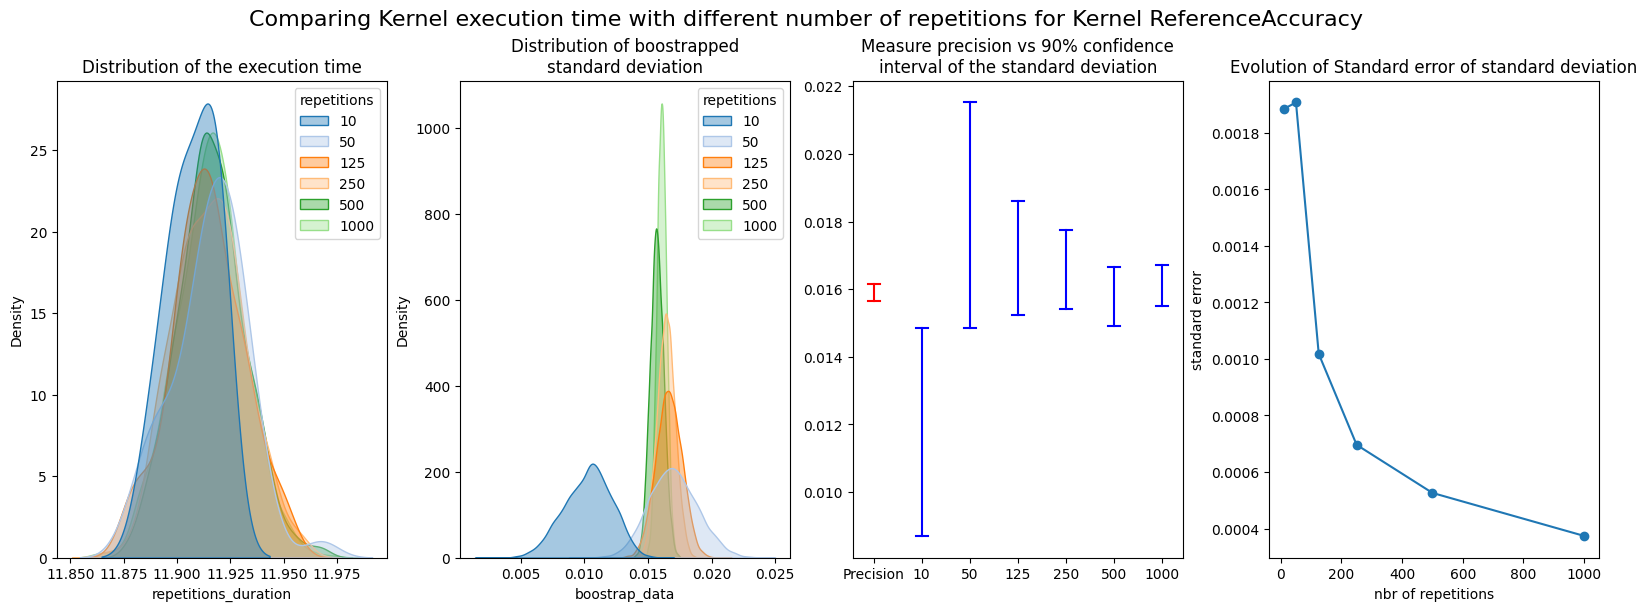

In [17]:
f = plot_compare_repetitions_single_version(df_experiment_boostraped)

In [18]:
def plot_compare_repetitions_all(df_experiment_boostrap):
    for version in df_experiment_boostrap["version"].unique():
        fig = plot_compare_repetitions_single_version(df_experiment_boostrap,version=version)
        plt.show()
        plt.close(fig)

In [19]:
#TODO 

#Import the new experiment

#scrap the new and old experiment to keep only BilateralReference, rename it to BlockingBilateral & OriginalBilateral

#Then combine in a dataframe, and compare the two of them

In [20]:
EXPERIMENT_ORIGINAL_VS_BLOCKING_FILE = "../src/build/csv/originalvsblockingvsnoflush_small.csv"
df_now = load_experiment(EXPERIMENT_ORIGINAL_VS_BLOCKING_FILE)
df_now_w5 = df_now[df_now["warmup"]==5].copy()
df_now_w5 = df_now_w5.sort_values(by='repetitions')
df_now_boot = load_n_compute_dataframe(dataframe=df_now_w5)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:02<00:00, 10.65it/s]


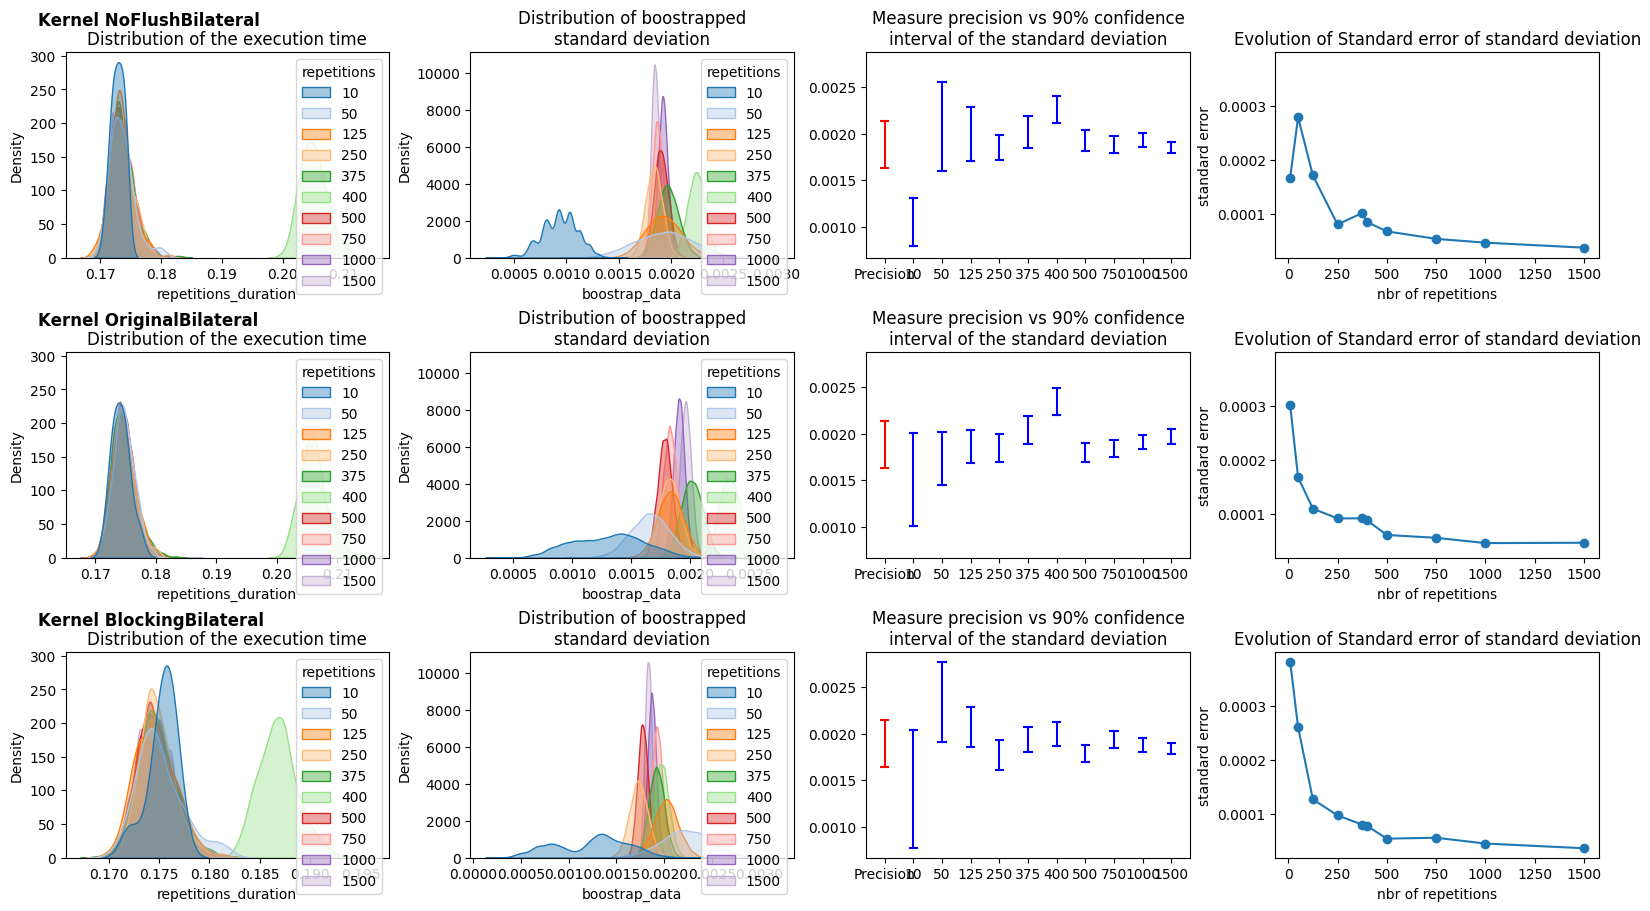

In [21]:
f = plot_compare_repetitions_multiple_version(df_now_boot)

 37%|███▋      | 10/27 [00:00<00:00, 87.20it/s]

100%|██████████| 27/27 [00:02<00:00, 11.10it/s]


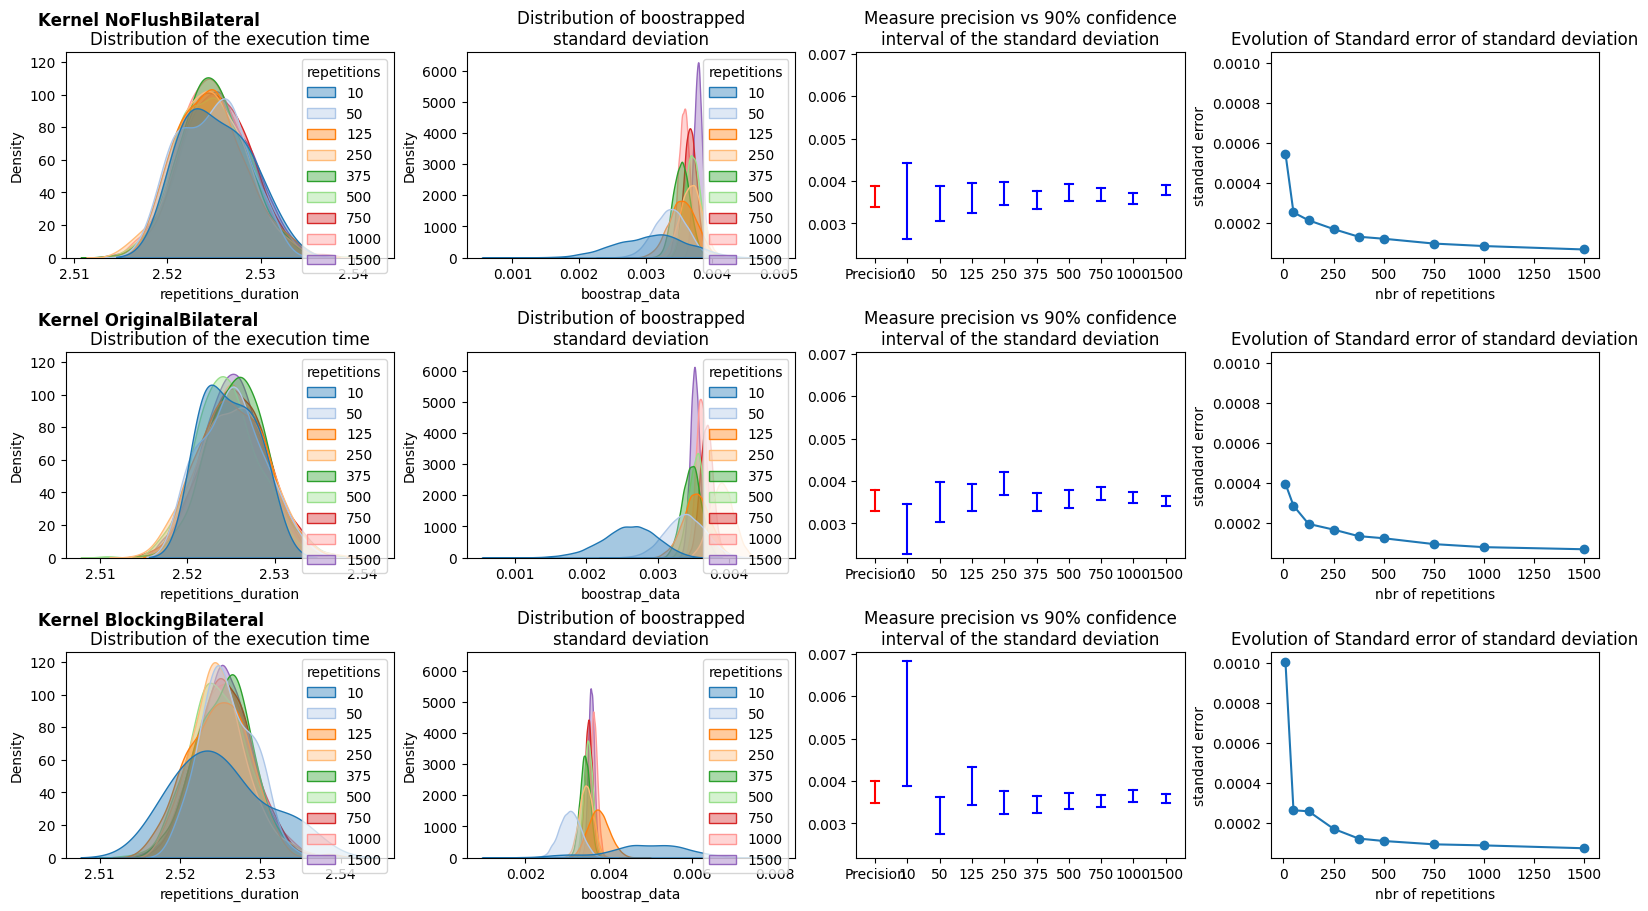

In [22]:
EXPERIMENT_ORIGINAL_VS_BLOCKING_FILE = "../src/build/csv/originalvsblockingvsnoflush_big.csv"
df_now = load_experiment(EXPERIMENT_ORIGINAL_VS_BLOCKING_FILE)
df_now_w5 = df_now[df_now["warmup"]==5].copy()
df_now_w5 = df_now_w5.sort_values(by='repetitions')
df_now_w5 = df_now_w5[df_now_w5['repetitions'] != 400]
df_now_boot = load_n_compute_dataframe(dataframe=df_now_w5)
f = plot_compare_repetitions_multiple_version(df_now_boot)

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [00:02<00:00, 11.14it/s]


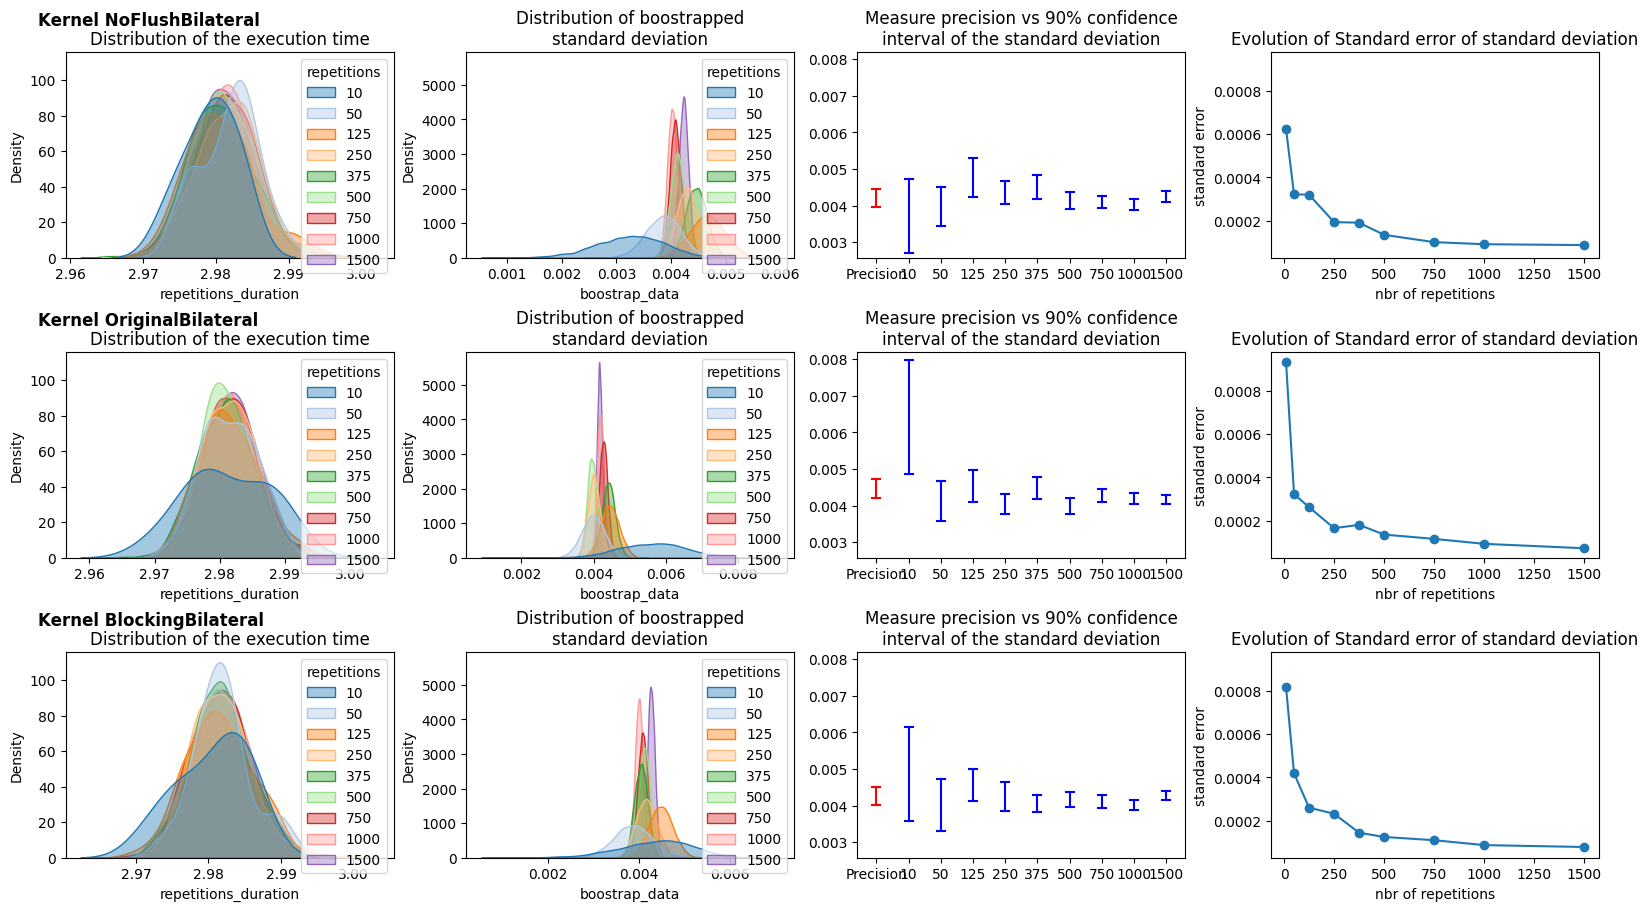

In [23]:
EXPERIMENT_ORIGINAL_VS_BLOCKING_LOCKED_FILE = "../src/build/csv/originalvsblockingvsnoflush_big_lock_clock.csv"
df_now = load_experiment(EXPERIMENT_ORIGINAL_VS_BLOCKING_LOCKED_FILE)
df_now_w5 = df_now[df_now["warmup"]==5].copy()
df_now_w5 = df_now_w5.sort_values(by='repetitions')
df_now_w5 = df_now_w5[df_now_w5['repetitions'] != 400]
df_now_boot = load_n_compute_dataframe(dataframe=df_now_w5)
f = plot_compare_repetitions_multiple_version(df_now_boot)

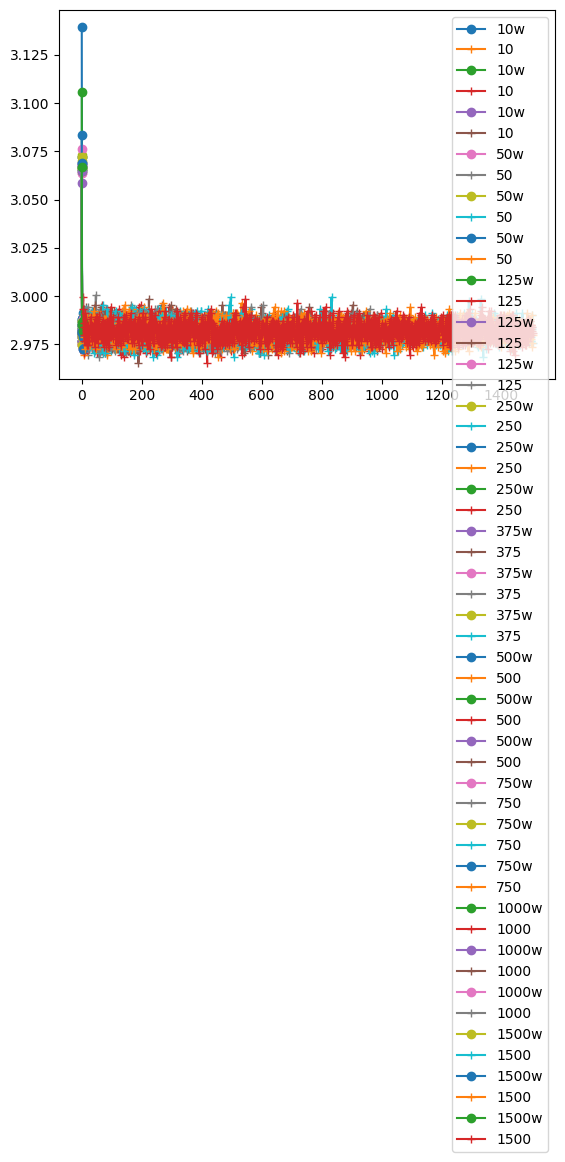

In [24]:
nbr = 0
for i,row in df_now.iterrows():
    if row.repetitions:
        plt.plot(np.arange(0,row.warmup),row.warmup_duration,label=str(row.repetitions)+"w",marker='o')
        #plt.plot(np.arange(row.warmup,min(20,row.repetitions)+row.warmup),row.repetitions_duration[:min(20,row.repetitions)],label=row.repetitions, marker="+")
        plt.plot(np.arange(row.warmup,row.repetitions+row.warmup),row.repetitions_duration,label=row.repetitions, marker="+")
        nbr+=1
plt.legend()
